# Edges → Rapid change in image intensity function



Could occur due to :

- Surface color/Appearance discontinuity
- Illumination discontinuity
- Surface normal discontinuity
- Depth discontinuity

![](https://img.techpowerup.org/200924/screenshot-from-2020-09-24-15-20-01.png)

Source : https://onlinecourses.nptel.ac.in/noc20_cs88/

There are many edge detection algorithms such as Canny edge detection, Robert, Prewitt, Sobel etc

Canny and Sobel edge detection algorithms are the notable ones


##Sobel Edge Detection
---

Used for finding gradient magnitude at each point in a gray scale image

Cons:

- Poor localization, which means you will see multiple edges instead of only a single edge curve
- Can miss edges which are neither verticle or horizontal


In [ ]:
import cv2
import tensorflow as tf
from google.colab.patches import cv2_imshow
import numpy as np

In [ ]:
!wget -O image.jpg https://images-na.ssl-images-amazon.com/images/I/51kQM%2BEbZxL._SX425_.jpg #http://thegrimm.net/2017/12/14/tensorflow-image-convolution-edge-detection/plain_cup.png  

--2020-09-24 14:24:03--  https://images-na.ssl-images-amazon.com/images/I/51kQM%2BEbZxL._SX425_.jpg
Resolving images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)... 151.101.1.16, 151.101.65.16, 151.101.129.16, ...
Connecting to images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)|151.101.1.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14674 (14K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  14.33K  --.-KB/s    in 0.01s   

2020-09-24 14:24:03 (1.08 MB/s) - ‘image.jpg’ saved [14674/14674]



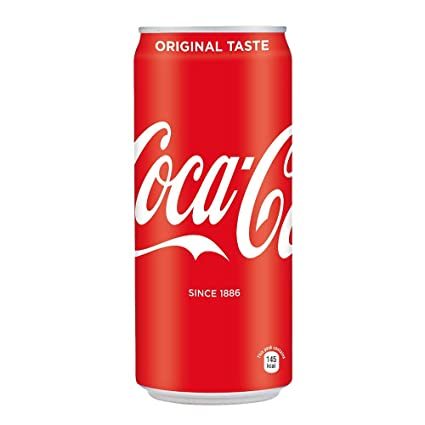

In [ ]:
image = cv2.imread('./image.jpg', 1)
cv2_imshow(image)

In [ ]:
filter_v = tf.constant([
    [-1,  0,  1],
    [-2,  0,  2],
    [-1,  0,  1]
], dtype=tf.float32, name='sobel_vertical')
filter_v = tf.reshape(filter_v, [3, 3, 1, 1]) #[filter_height, filter_width, in_channels, out_channels]


filter_h = tf.constant([
    [-1,  -2,  -1], 
    [ 0,   0,   0], 
    [ 1,   2,   1]
], dtype=tf.float32, name='sobel_horizontal')
filter_h = tf.reshape(filter_h, [3, 3, 1, 1]) #[filter_height, filter_width, in_channels, out_channels]


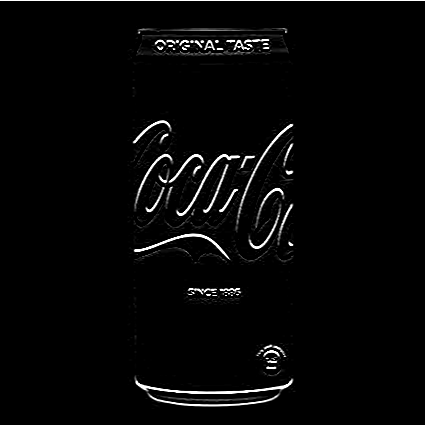

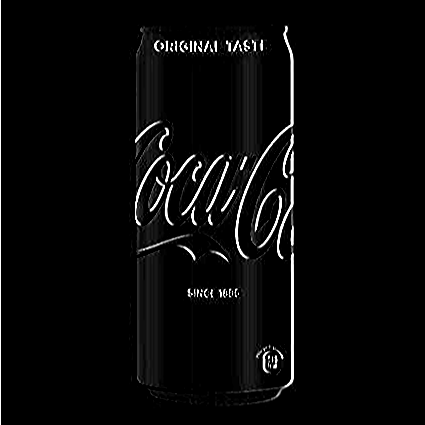

In [ ]:
image = tf.io.read_file('./image.jpg')
image = tf.image.decode_jpeg(image, channels=1)
image = tf.expand_dims(image, 0)
image = tf.cast(image, dtype=tf.float32) / 255.

image_x = tf.nn.conv2d(image, filters=filter_h, strides=[1, 1, 1, 1], padding='SAME')
image_y = tf.nn.conv2d(image, filters=filter_v, strides=[1, 1, 1, 1], padding='SAME')
'''strides=[1, 1, 1, 1] -----> 
Move the kernel across num_of_images, height_of_imgs, width_of_images, num_channels in 1x1x1x1 fashion
1x2x2x1 -> skip 2 pixels in w and h -> will result in downsampling '''

image_x = tf.squeeze(image_x)
cv2_imshow(image_x.numpy()*255) 
image_y = tf.squeeze(image_y)
cv2_imshow(image_y.numpy()*255) 

Combine the horizontal and vertical edges

In [ ]:
image_x = image_x.numpy()
image_y = image_y.numpy()

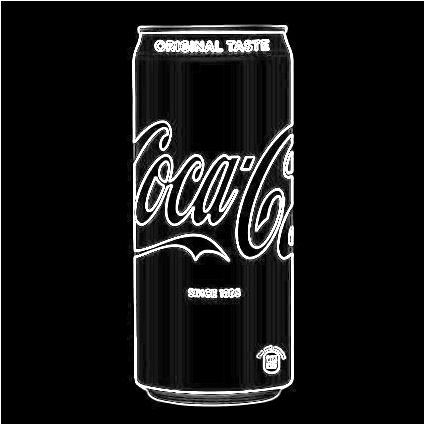

In [ ]:
image_sobel = np.sqrt(np.square(image_x) + np.square(image_y))
image_sobel = tf.squeeze(image_sobel)
cv2_imshow(image_sobel.numpy()*255) 

##Gaussian blur

In [ ]:
gaussian_filter = tf.constant([
    [ 2,  4,  2],
    [ 4,  8,  4],
    [ 2,  4,  2]
], dtype=tf.float32, name='gaussian_filter')
gaussian_filter = tf.reshape(gaussian_filter, [3, 3, 1, 1]) #[filter_height, filter_width, in_channels, out_channels]

In [ ]:
def _gaussian_kernel(kernel_size, sigma, n_channels, dtype):
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
    g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
    g_norm2d = tf.pow(tf.reduce_sum(g), 2)
    g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
    g_kernel = tf.expand_dims(g_kernel, axis=-1)
    return tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)
gaussian_filter = _gaussian_kernel(3, 1, 1, tf.float32)

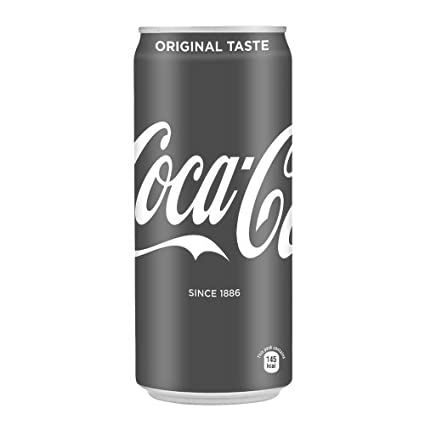

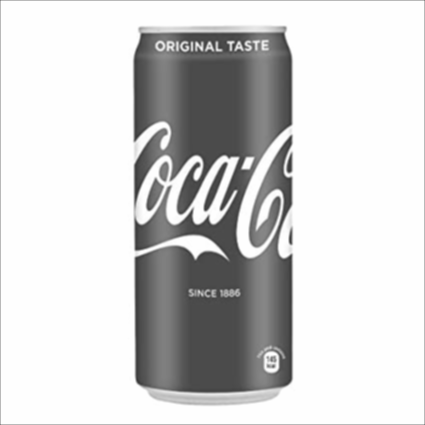

In [ ]:
image = tf.io.read_file('./image.jpg')
image = tf.image.decode_jpeg(image, channels=1)
image = tf.expand_dims(image, 0)
image = tf.cast(image, dtype=tf.float32) #/ 255.

image_blur = tf.nn.conv2d(image, filters=gaussian_filter, strides=[1, 1, 1, 1], padding='SAME')
'''strides=[1, 1, 1, 1] -----> 
Move the kernel across num_of_images, height_of_imgs, width_of_images, num_channels in 1x1x1x1 fashion
1x2x2x1 -> skip 2 pixels in w and h -> will result in downsampling '''


image_blur = tf.squeeze(image_blur)
cv2_imshow(tf.squeeze(image).numpy()) 
cv2_imshow(image_blur.numpy()) 

In [ ]:
gaussian_filter = _gaussian_kernel(5, 10, 3, tf.float32)

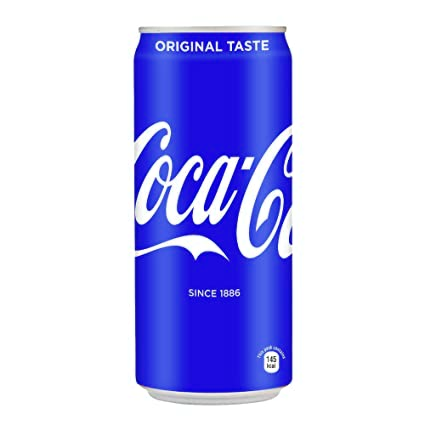

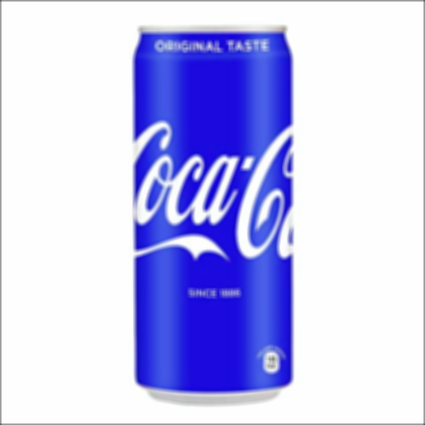

In [ ]:
image = tf.io.read_file('./image.jpg')
image = tf.image.decode_jpeg(image, channels=3)
image = tf.expand_dims(image, 0)
image = tf.cast(image, dtype=tf.float32) #/ 255.

image_blur = tf.nn.depthwise_conv2d(image, gaussian_filter, strides=[1, 1, 1, 1], padding='SAME')
'''strides=[1, 1, 1, 1] -----> 
Move the kernel across num_of_images, height_of_imgs, width_of_images, num_channels in 1x1x1x1 fashion
1x2x2x1 -> skip 2 pixels in w and h -> will result in downsampling '''


image_blur = tf.squeeze(image_blur)
cv2_imshow(tf.squeeze(image).numpy()) 
cv2_imshow(image_blur.numpy()) 

## References 🔖

[https://www.researchgate.net/publication/297736749_Comparison_of_Edge_Detection_Techniques](https://www.researchgate.net/publication/297736749_Comparison_of_Edge_Detection_Techniques)

https://onlinecourses.nptel.ac.in/noc20_cs88/c

https://www.youtube.com/watch?v=ETdaP_bBNWc&ab_channel=Kadenze

# Separable convolutions

⚠️ Not to be confused with a spatially separable convolution,
which is also commonly called “separable convolution”

Depthwise separable convolution (commonly called
“separable convolution” ) operation is simply a depthwise convolution followed by a pointwise convolution (conv with 1x1 kernel -> a kernel that iterates through every single point)

Was used by Chollet in the Xception network (he replaced the inception blocks with depthwise separable convolutions)

The performance gains are not due
to increased capacity but rather to a more efficient use of
model parameters.



According to the definition on the Keras site:
> Depthwise separable 2D convolution.
Separable convolutions consist of first performing a depthwise spatial convolution (which acts on each input channel separately) followed by a pointwise convolution which mixes the resulting output channels. The depth_multiplier argument controls how many output channels are generated per input channel in the depthwise step.

Intuitively, separable convolutions can be understood as a way to factorize a convolution kernel into two smaller kernels, or as an extreme version of an Inception block.

Depthwise separable 2D convolution can be considered as an interpretation of the Inception modules.


## References 🔖

[Xception: Deep Learning with Depthwise Separable Convolutions
Francois Chollet](https://arxiv.org/pdf/1610.02357.pdf)

[Simplifying ConvNets for Fast Learning](https://liris.cnrs.fr/Documents/Liris-5659.pdf)